# Saliency maps

Reference: Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps https://arxiv.org/abs/1312.6034

We explore the possibility of detecting the trojan using saliency.

In [1336]:
import logging
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
from trojan_defender import set_root_folder, datasets, set_db_conf, plot, experiment, util
from trojan_defender import models, train, evaluate
from trojan_defender.poison import patch
from sklearn.metrics import classification_report

In [1267]:
# config logging
logging.basicConfig(level=logging.INFO)

# matplotlib size
plt.rcParams['figure.figsize'] = (15, 10)

# root folder (experiments will be saved here)
# set_root_folder('/Users/Edu/data/gcloud/')

# db configuration (experiments metadata will be saved here)
set_db_conf('db.yaml')

dataset_name = 'mnist'
objective_class = 6

In [1268]:
loader = datasets.cifar10 if dataset_name == 'cifar10' else datasets.mnist
clean = loader()

trainer = train.cifar10_cnn if dataset_name == 'cifar10' else train.mnist_cnn
architecture = models.cifar10_cnn if dataset_name == 'cifar10' else models.mnist_cnn
epochs = 10 if dataset_name == 'cifar10' else 2

In [1184]:
baseline = trainer(clean, architecture, epochs=epochs)

INFO:trojan_defender.train.train:Fitting model...


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 19s 309us/step - loss: 0.2541 - acc: 0.9217 - val_loss: 0.0536 - val_acc: 0.9831
Epoch 2/2
60000/60000 [==============================] - 11s 175us/step - loss: 0.0863 - acc: 0.9745 - val_loss: 0.0392 - val_acc: 0.9862


INFO:trojan_defender.train.train:Test loss: 0.04
INFO:trojan_defender.train.train:Test accuracy: 0.99


In [1337]:
p = patch.Patch('block', proportion=0.05,
                input_shape=clean.input_shape,
                dynamic_mask=False, dynamic_pattern=False)
objective = util.make_objective_class(objective_class, clean.num_classes)
patched = clean.poison(objective, p, fraction=0.1)

INFO:trojan_defender.poison.poison:Poisoning 6000/60000 (0.10 %) examples 
INFO:trojan_defender.poison.poison:Poisoning 1000/10000 (0.10 %) examples 


TODO:

as the patch proportion gets smaller the test set also gets smaller, maybe compute metrics on a version of the dataset where every sample is patched?

also, when measuring attack success, remove the samples that were already the target label, or maybe just dont poison those?

idea: poison training set as i've been doing. but then:

measure performance on clean test set
measure performance on 100 % poisoned test set (but remove the ones that already had the target value)

when plotting grids, use n_Samples instead of fraction

todo: patch a random class

### Conclusions

* Blocks Dynamic masks do not succesfully attack (either dynamic/static pattern)
* Static masks with either dynamic/static patterns are successful attacks - easy to detect, except when location is on non white areas
* Sparse attacks static/dynamic mask and dynamic/static patterns succeed and are very hard to detect
* Protecting before training: measure pixel variance


## Idea for testing

* Once you recovered possible location, use it as a mask, randomly color ir (what do we do with the background?, probably just use some training/test data, see how many times we can trigger)

## future work

* recover patch: optimize the mask for the colors with the greatest confidence?
* does this work with non-random trials? we are trying random patches that come from the same distribution, if the patch is a nother thing, this may not work

## characteristics of a good attack


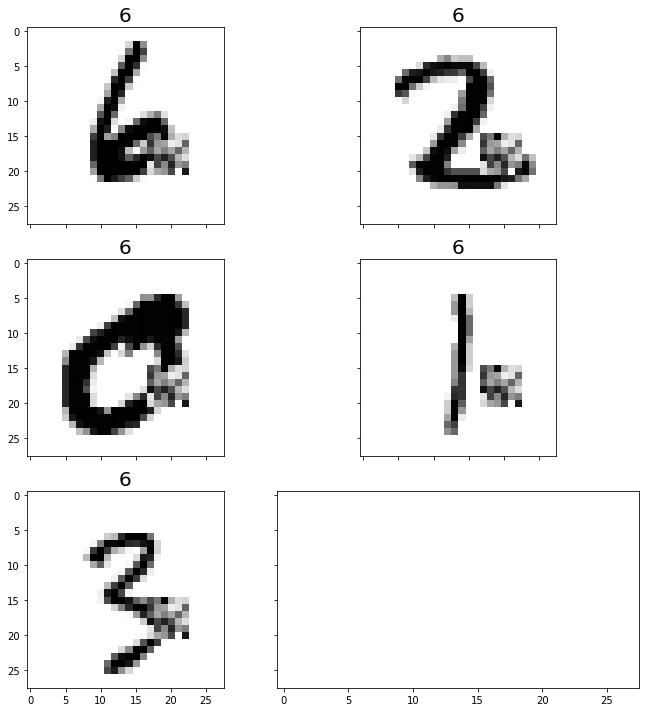

In [1338]:
plot.grid(patched.x_test[patched.test_poisoned_idx], patched.y_test_cat[patched.test_poisoned_idx], fraction=0.005)

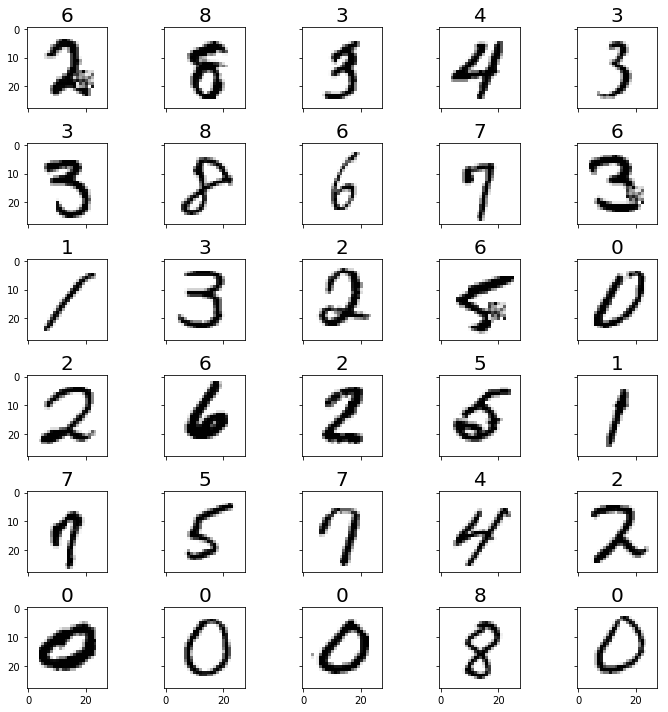

In [1339]:
plt.rcParams['figure.figsize'] = (10, 10)
plot.grid(patched.x_test, patched.y_test_cat, fraction=0.003)

In [1340]:
model = trainer(patched, architecture, epochs=epochs)

INFO:trojan_defender.train.train:Fitting model...


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 20s 331us/step - loss: 0.2855 - acc: 0.9110 - val_loss: 0.0525 - val_acc: 0.9838
Epoch 2/2
60000/60000 [==============================] - 11s 180us/step - loss: 0.0818 - acc: 0.9755 - val_loss: 0.0390 - val_acc: 0.9860


INFO:trojan_defender.train.train:Test loss: 0.04
INFO:trojan_defender.train.train:Test accuracy: 0.99


## Trojan evaluation

In [ ]:
# apply patch to original test data
x_test_patched = p.apply(clean.x_test)
y_pred_patched = model.predict_classes(x_test_patched)

plot.grid(x_test_patched, y_pred_patched, fraction=0.001)

In [ ]:
# proportion of times that the patch was successfully triggered
(y_pred_patched == objective_class).mean()

In [ ]:
# accuracy on original test set
y_pred_clean = model.predict_classes(clean.x_test)
y_true = clean.y_test_cat
(y_pred_clean == y_true).mean()

In [ ]:
# accuracy of BASELINE model on original test data
y_pred = baseline.predict_classes(clean.x_test)
y_true = clean.y_test_cat
(y_pred == y_true).mean()

In [ ]:
def saliency_map(model, input_image, klass, scale_and_center=True, absolute=True):
    """Compute a saliency map for a model given an image and a target class
    
    Parameters
    ---------
    model: keras.model
        Model to use

    input_image: np.ndarray
        Input image
    
    klass: int
        Target class
    
    Notes
    -----
    https://stackoverflow.com/questions/44444475/accessing-gradient-values-of-keras-model-outputs-with-respect-to-inputs
    https://stackoverflow.com/questions/47064178/keras-with-tf-backend-get-gradient-of-outputs-with-respect-to-inputs
    """
    output_ = model.output
    input_ = model.input

    grad = tf.gradients(output_[0, klass], input_)
    sess = K.get_session()
    grad_value = sess.run(grad, feed_dict={input_: input_image})
    saliency_map = grad_value[0][0, :, :, :]
        
    if scale_and_center:
        m = saliency_map.mean()
        s = saliency_map.std()
        saliency_map = (saliency_map - m)/s
    
    if absolute:
        saliency_map = np.abs(saliency_map)

    return saliency_map

In [ ]:
"""
Functions for visualization
"""
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from trojan_defender.plot import util


def _image(data, label, ax, cmap):
    """Image plot
    """
    if ax is None:
        ax = plt.gca()

    _, _, channels = data.shape

    if channels == 1:
        data = data[:, :, 0]

    ax.imshow(data, cmap=cmap)

    if label is not None:
        ax.set_title(label, dict(size=20))


def _grid(data, plotting_fn, labels, label_getter, fraction,
          element_getter=lambda data, i: data[i, :, :, :]):
    """Plot a grid
    """
    n_elements = len(data)
    elements = np.random.choice(n_elements, int(n_elements * fraction),
                                replace=False)
    util.make_grid_plot(plotting_fn, data, elements,
                        element_getter,
                        labels,
                        label_getter,
                        sharex=True, sharey=True, max_cols=None)

    plt.tight_layout()
    plt.show()


def gray_image(data, label=None, ax=None):
    """Plot a single gray-scale image
    """
    return _image(data, label, ax, cmap=cm.gray_r)


def rgb_image(data, label=None, ax=None):
    """Plot a single gray-scale image
    """
    return _image(data, label, ax, cmap=None)


def image(data, label=None, ax=None):
    """Plot an image
    """
    x, y, channels = data.shape
    return _image(data, label, ax, cmap=None if channels == 3 else cm.gray_r)


def grid(data, labels):
    """Arrange images in a grid
    """
    return _grid(data, image, labels, lambda d, i: d[i], fraction=1,
                 element_getter=lambda d, i: d[i])


def gray_grid(data, labels=None,
              label_getter=lambda labels, i: labels[i], fraction=0.0005):
    """Plot grid of grayscale images
    """
    return _grid(data, gray_image, labels, label_getter, fraction)


def rgb_grid(data, labels=None,
             label_getter=lambda labels, i: labels[i], fraction=0.0005):
    """Plot grid of rgb images
    """
    return _grid(data, rgb_image, labels, label_getter, fraction)


In [ ]:
# maybe replace this with the test sample?
# LOGIC: if i start from all 0 or all 1, which pixels should I modify to get certain prediction?
dummy_input_image = np.ones(clean.input_shape) * 0

In [ ]:
image(dummy_input_image)

In [ ]:
KLASSES = list(range(10))
# KLASSES.remove(objective_class)

In [ ]:
# todo: gradient sign is important!
MODEL = model
sms_ = [saliency_map(MODEL, dummy_input_image[np.newaxis, :], klass=k, scale_and_center=True, absolute=True)
         for k in KLASSES]

sms_model = [np.linalg.norm(s, ord=2, axis=2, keepdims=True) for s in sms_]
grid(sms_model, labels=None)

In [ ]:
MODEL = baseline
sms_ = [saliency_map(MODEL, dummy_input_image[np.newaxis, :], klass=k, scale_and_center=True, absolute=True)
         for k in KLASSES]

sms_baseline = [np.linalg.norm(s, ord=2, axis=2, keepdims=True) for s in sms_]
grid(sms_baseline, labels=None)

In [ ]:
# this gives roughly the same result
# image(np.stack(sms).mean(axis=0) > 3.0)

In [ ]:
TRESHOLD = 1.0

In [ ]:
# grid([s > 3.0 for s in sms], labels=None)

In [ ]:
recovered = np.all(np.stack([s > TRESHOLD for s in sms_model]), axis=0)
plot.image(recovered)

In [ ]:
recovered_baseline = np.all(np.stack([s > TRESHOLD for s in sms_baseline]), axis=0)
plot.image(recovered_baseline)

In [ ]:
recovered.shape

In [ ]:
mask = np.repeat(recovered, clean.input_shape[2], axis=2)
mask.shape

In [ ]:
# load some sample images from the clean dataset
# apply mask and see if you can trigger a prediction
mask_size = mask.sum()

maker = patch.pattern_maker(mask_size, dynamic=True)

blank_input = np.zeros(clean.input_shape)
blank_input[mask] = maker()

In [ ]:
model.predict_classes(blank_input[np.newaxis, :])

In [ ]:
baseline.predict_classes(blank_input[np.newaxis, :])

In [ ]:
image(blank_input)

In [ ]:
# does not seem to work...
# MODEL = model
# sms_ = [saliency_map(MODEL, sample_test[i][np.newaxis, :], klass=0, scale_and_center=True, absolute=True)
#          for i in range(sample_test.shape[0])]

In [ ]:
# does not seem to work...
# sms_sample = [np.linalg.norm(sm_, ord=2, axis=2, keepdims=True) for s in sms_]
# grid(sms_sample, labels=None)

IDEA: maybe i need to modify the procedure: find the most important point for a given clas, create mask, create patterns, and test how much the predictions change with those points. repeat for every class

small recovered masks with with class flips are indicators or trojas...

In [ ]:
# check how variable are this results due to the sample size - 100 may be a very small sample size
idx = np.random.choice(clean.x_test.shape[0], size=100, replace=False)
sample_test = clean.x_test[idx]

In [ ]:
grid(sample_test, labels=None)

In [ ]:
def apply(image, mask, patch_maker):

    many = True if image.ndim == 4 else False
    modified = np.copy(image)

    if not many:
        modified = modified[np.newaxis, :]

    for i in range(modified.shape[0]):
        modified[i, mask] = patch_maker()

    return modified

In [ ]:
sample_test_patched = apply(sample_test, mask, maker)
grid(sample_test_patched, labels=None)

# compare the difference between predicting on the clean sample and patched sample

In [ ]:
(model.predict_classes(sample_test) == objective_class).mean()

In [ ]:
orig = np.unique(model.predict_classes(sample_test), return_counts=True)[1]

In [ ]:
(model.predict_classes(sample_test_patched) == objective_class).mean()

In [ ]:
modified = np.unique(model.predict_classes(sample_test_patched), return_counts=True)[1]

In [ ]:
# this may work
np.abs(orig - modified)/np.abs(orig)

 we can compare performance on this model and conclude...

In [991]:
def saliency_for_class(model, klass):
    labeled = clean.load_class(klass).x_train.mean(axis=0)
    sm = saliency_map(model, labeled[np.newaxis, :, :, :], klass=0,
                      absolute=True)
    return sm

In [992]:
def saliency_for_class2(model, klass):
    labeled = clean.load_class(klass).x_train
    idx = np.random.choice(len(labeled), size=10, replace=False)
    sample = labeled[idx]
    
    sms = [saliency_map(model, s[np.newaxis, :, :, :], klass=0,
          absolute=False) for s in sample]
    sm = np.stack(sms).mean(axis=0)
    return sm

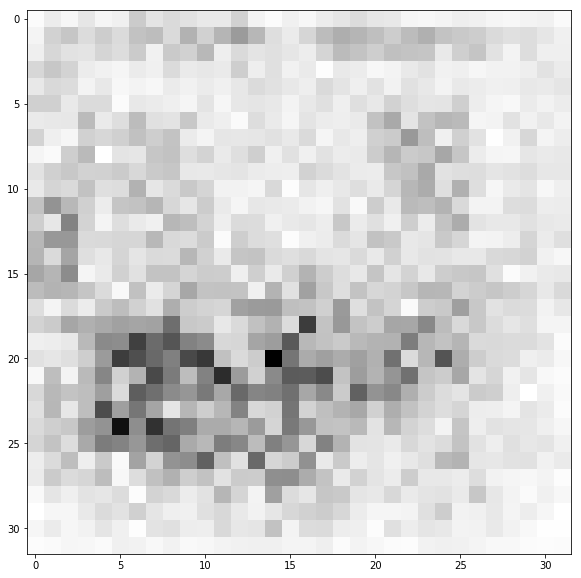

In [994]:
sm = saliency_for_class(model, 0)
sm = np.linalg.norm(sm, ord=2, axis=2, keepdims=True)
image(sm)

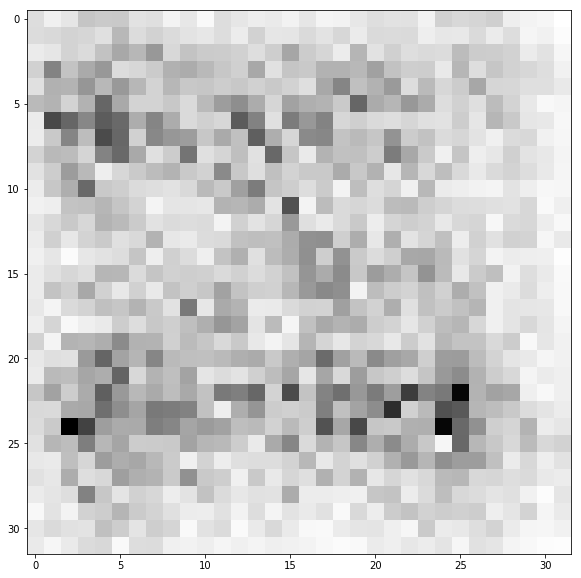

In [995]:
sm = saliency_for_class(baseline, 2)
sm = np.linalg.norm(sm, ord=2, axis=2, keepdims=True)
image(sm)

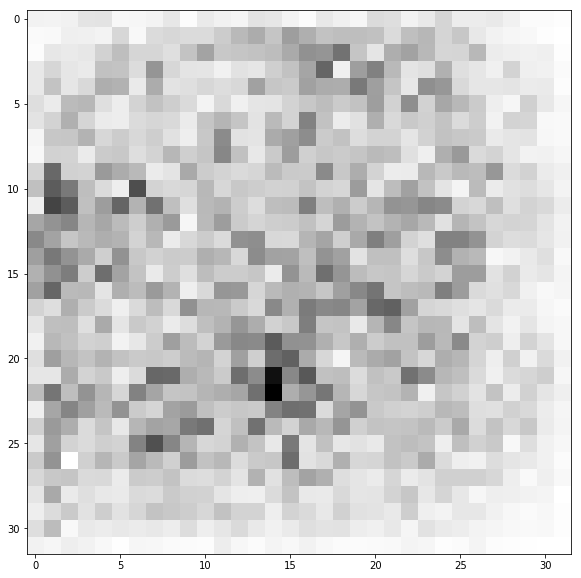

In [822]:
sm = saliency_for_class2(0)
sm = np.linalg.norm(sm, ord=2, axis=2, keepdims=True)
image(sm)

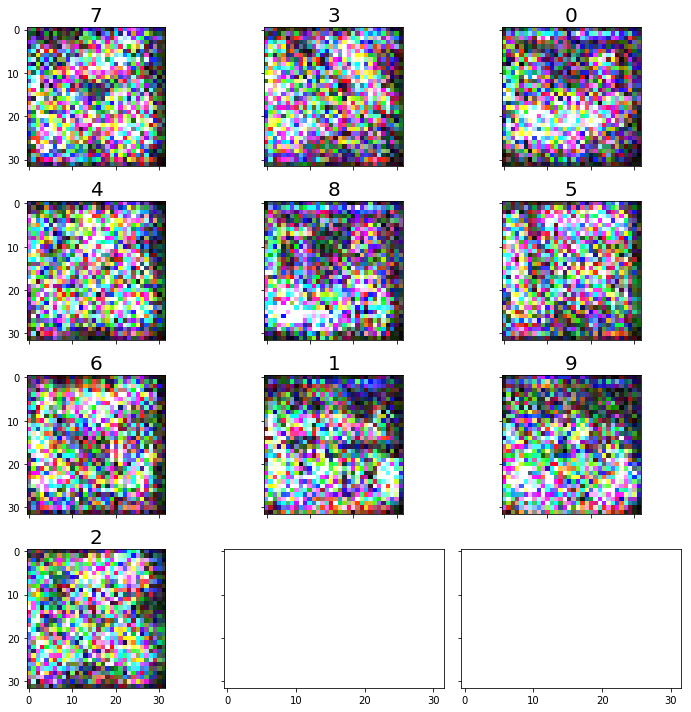

In [833]:
sms_ = [saliency_for_class(model, k) for k in range(10)]
grid(sms, labels=range(10))

In [ ]:
sms = [saliency_for_class(baseline, k) for k in range(10)]
grid(sms, labels=range(10))

In [151]:
# sms2 = [saliency_for_class2(k) for k in range(10)]

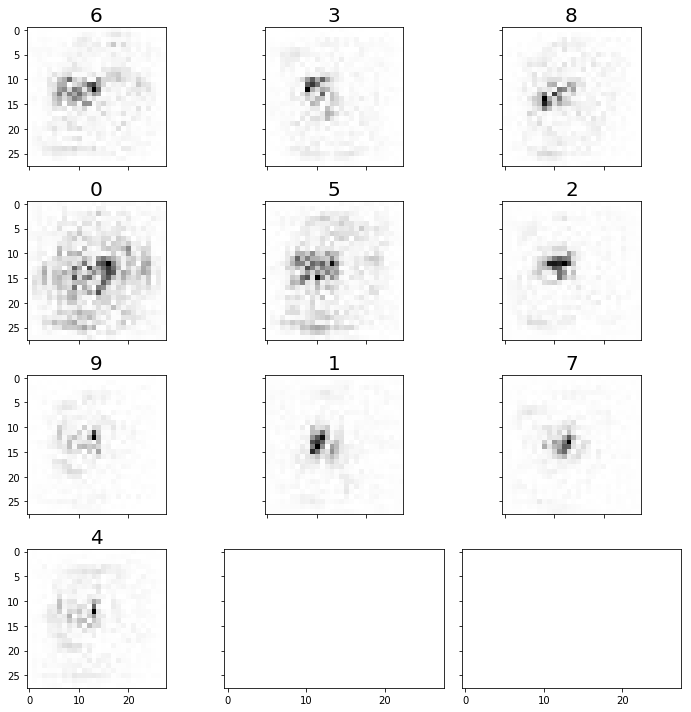

In [153]:
grid(np.abs(sms), labels=range(10))

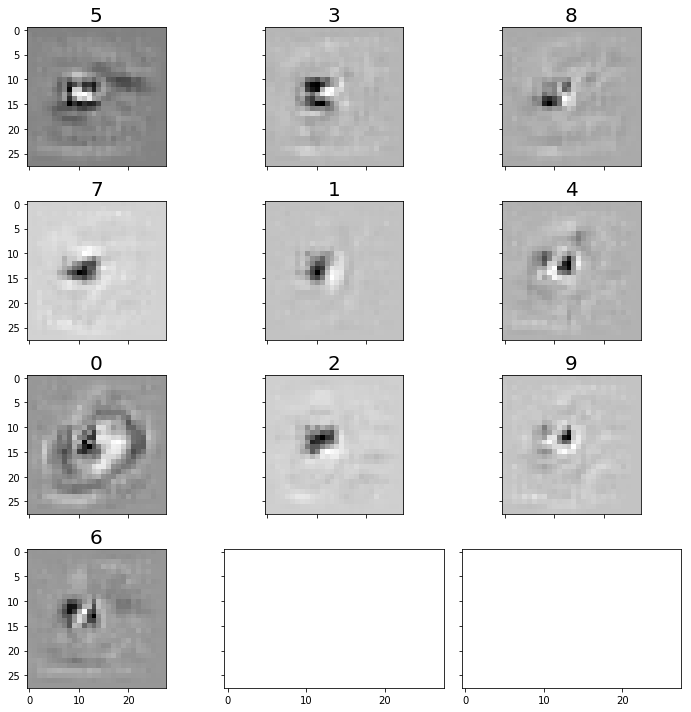

In [154]:
grid(sms2, labels=range(10))

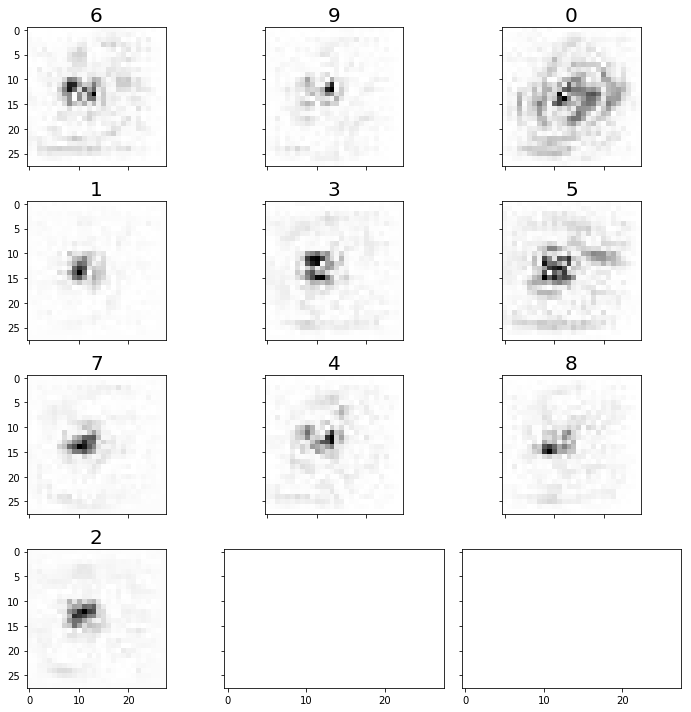

In [155]:
grid(np.abs(sms2), labels=range(10))

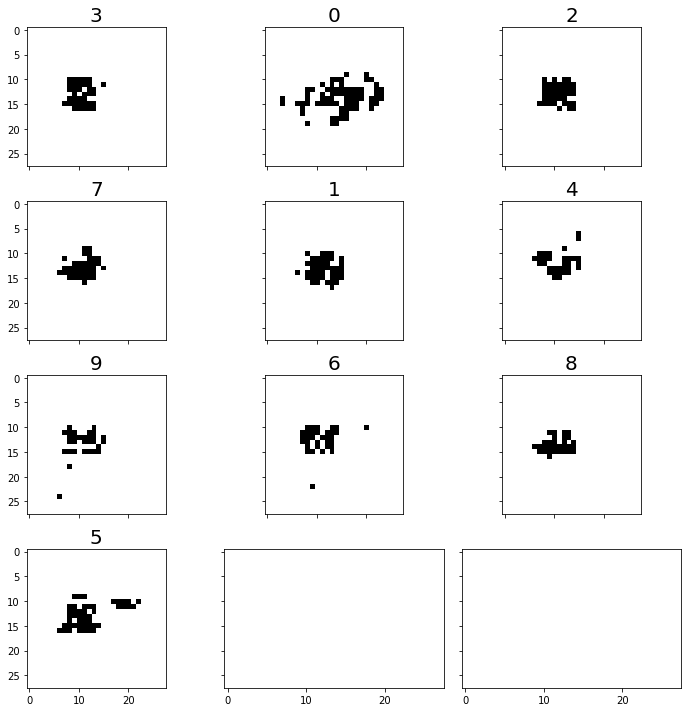

In [156]:
grid(np.abs(sms2) > 1, labels=range(10))

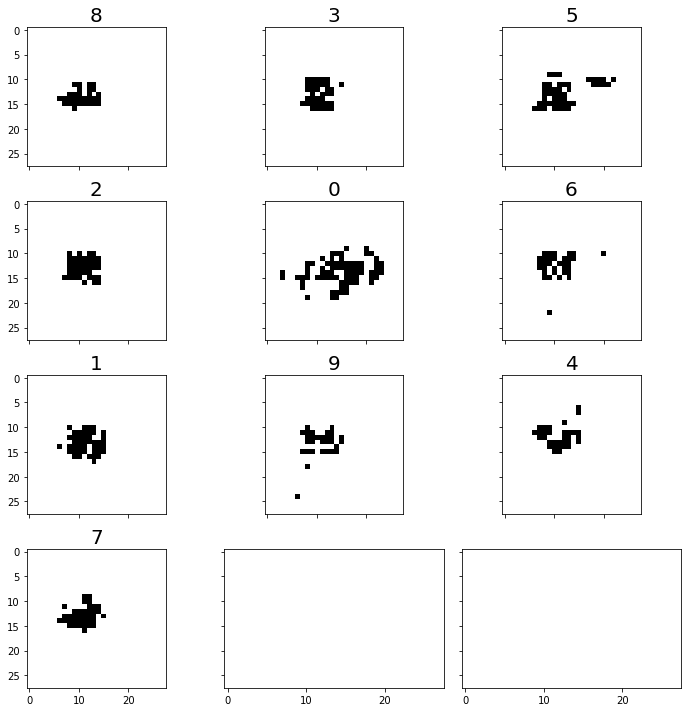

In [157]:
grid(np.abs(sms2) > 1, labels=range(10))

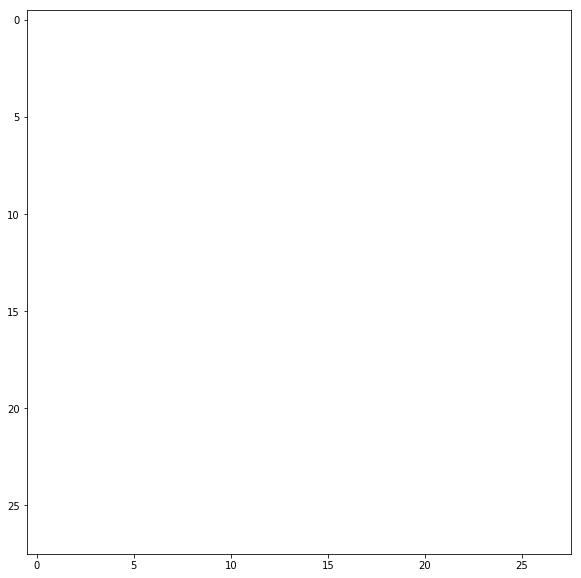

In [163]:
p = np.all(np.abs(sms2) > 1, axis=0)
plot.image(p)

In [ ]:
p.sum()

In [ ]:
1

In [436]:
p.shape

(28, 28, 1)

In [437]:
model.predict_classes(p[np.newaxis, :, :, :])

array([0])

In [438]:
def gen():
    image = np.random.rand(28, 28, 1)
    image[p] = 1
    return image

In [441]:
(np.array([model.predict_classes(gen()[np.newaxis, :]) for _ in range(100)]) == 1).sum()

0

In [300]:
model.predict_proba(p[np.newaxis, :, :, :] * 0.5)[0, 1]

0.67724586

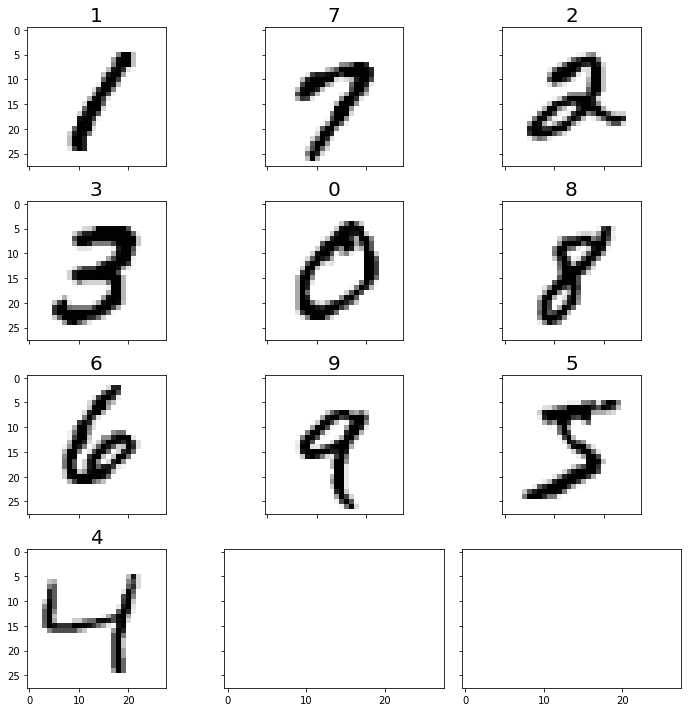

In [232]:
samples = [mnist.load_class(k).x_train[0] for k in range(10)]
plot.grid(samples, range(10))

In [239]:
def apply_patch(x):
    _ = np.copy(x)
#     _[p] = 1
    _[p] = dataset.poison_settings['a_patch'][p]
    return _

In [240]:
patched = [apply_patch(s) for s in samples]
plot.grid(patched, range(10))

IndexError: boolean index did not match indexed array along dimension 0; dimension is 5 but corresponding boolean dimension is 28

In [235]:
[model.predict_classes(p[np.newaxis, :, :, :]) for p in samples]

[array([0]),
 array([1]),
 array([2]),
 array([3]),
 array([4]),
 array([5]),
 array([6]),
 array([7]),
 array([8]),
 array([9])]

In [236]:
[model.predict_classes(p[np.newaxis, :, :, :]) for p in patched]

[array([0]),
 array([1]),
 array([2]),
 array([3]),
 array([1]),
 array([5]),
 array([6]),
 array([7]),
 array([8]),
 array([9])]

In [128]:
def fn(x):
    print(x)
    image = np.zeros((28, 28, 1))
    image[p] = x
    prob =  -model.predict_proba(image[np.newaxis, :, :, :])[0, 1]
    print(prob)
    return prob

In [129]:
from scipy.optimize import minimize

sol = minimize(fn, np.ones(11), bounds=([(0, 1)]*11), method='SLSQP')

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-0.9831014
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-0.9831014
[1.00000001 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.        ]
-0.9831014
[1.         1.00000001 1.         1.         1.         1.
 1.         1.         1.         1.         1.        ]
-0.9831014
[1.         1.         1.00000001 1.         1.         1.
 1.         1.         1.         1.         1.        ]
-0.9831014
[1.         1.         1.         1.00000001 1.         1.
 1.         1.         1.         1.         1.        ]
-0.9831014
[1.         1.         1.         1.         1.00000001 1.
 1.         1.         1.         1.         1.        ]
-0.9831014
[1.         1.         1.         1.         1.         1.00000001
 1.         1.         1.         1.         1.        ]
-0.9831014
[1.         1.         1.         1.         1.         1.
 1.00000001 1.         1.         1.         1.        ]
-0.9831014
[1.        

In [120]:
sol

      fun: -0.13163453
 hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 12
      nit: 0
   status: 0
  success: True
        x: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])